In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.utils import plot_model

In [2]:
#Import Dataframe
folder_path = r'data/'
csv_path = folder_path + 'Fulldata_age.csv'
df = pd.read_csv(csv_path)

In [3]:
full_df = df.sample(frac=0.1, random_state=42)

train_df = full_df.copy()
train_df = train_df[train_df['Value_SoH'] > 0.79] #nnly Data between 1 and 0.79 SoH

#Set the features for the Pipeline
training_columns = ['Time','Value_U','Value_I','Value_SoC','Cumulative_Ah','Value_Age','Value_NumCharge','Value_SoH','Value_NcT80']
train_df = train_df[training_columns]
train_df.info()
train_df.head()

#Select the Prediciton features
pred_columns = ['Value_SoH','Value_NcT80']

<class 'pandas.core.frame.DataFrame'>
Index: 161015 entries, 119162 to 1119089
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Time             161015 non-null  int64  
 1   Value_U          161015 non-null  float64
 2   Value_I          161015 non-null  float64
 3   Value_SoC        161015 non-null  float64
 4   Cumulative_Ah    161015 non-null  float64
 5   Value_Age        161015 non-null  int64  
 6   Value_NumCharge  161015 non-null  int64  
 7   Value_SoH        161015 non-null  float64
 8   Value_NcT80      161015 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 12.3 MB


Value_SoH
Time               0.060915
Value_U            0.030686
Value_I            0.010144
Value_SoC          0.044546
Value_State             NaN
Value_SoH          1.000000
Time_Diff               NaN
Value_Ah           0.010147
Value_kWh          0.009871
Cumulative_Ah     -0.950637
Cumulative_kWh    -0.951587
Value_Age         -0.724972
Value_NumCharge   -0.900846
AhpSoC             0.999024
Folder             0.082920
Value_AgeT80       0.797144
Value_NcT80        0.921806
Name: Value_SoH, dtype: float64
Value_NcT80
Time              -0.011632
Value_U           -0.043124
Value_I            0.010288
Value_SoC         -0.006754
Value_State             NaN
Value_SoH          0.921806
Time_Diff               NaN
Value_Ah           0.010297
Value_kWh          0.010510
Cumulative_Ah     -0.825653
Cumulative_kWh    -0.826206
Value_Age         -0.748638
Value_NumCharge   -0.763140
AhpSoC             0.908734
Folder            -0.099249
Value_AgeT80       0.557088
Value_NcT80        1.0

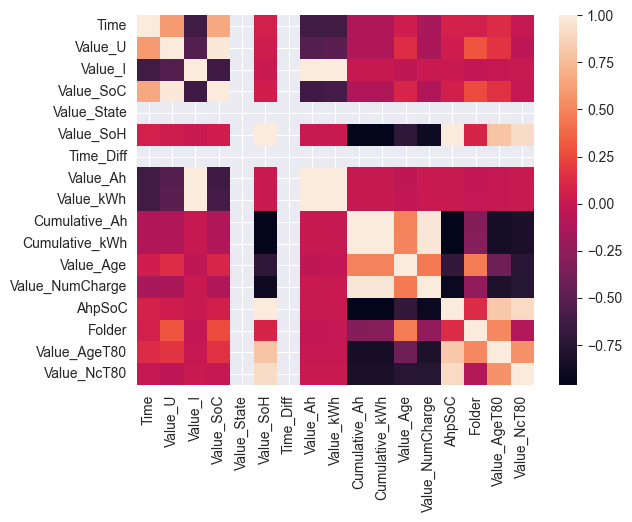

In [4]:
#Build Correlation Matrix
corr = full_df.corr()
fig, ax = plt.subplots()
sns.heatmap(corr)
for col in pred_columns:
  print(col)
  print(corr[col])

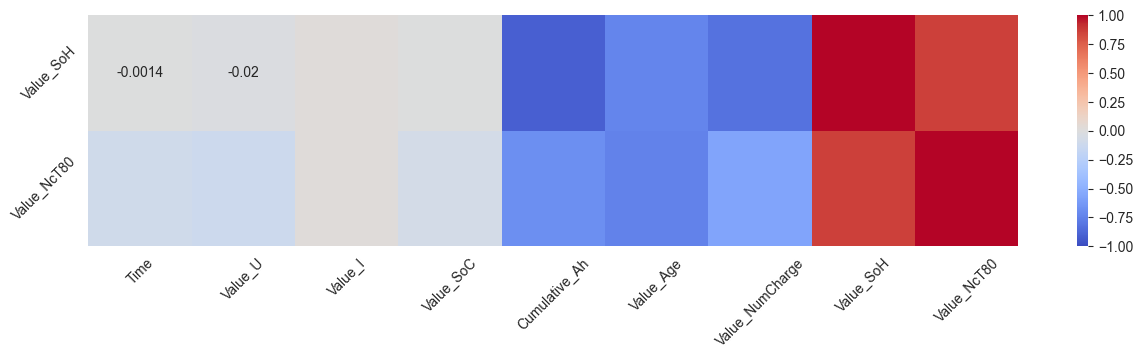

Value_SoH
Time              -0.001372
Value_U           -0.020421
Value_I            0.021878
Value_SoC         -0.002235
Cumulative_Ah     -0.907096
Value_Age         -0.728028
Value_NumCharge   -0.822768
Value_SoH          1.000000
Value_NcT80        0.863706
Name: Value_SoH, dtype: float64
Value_NcT80
Time              -0.098556
Value_U           -0.123344
Value_I            0.020883
Value_SoC         -0.073026
Cumulative_Ah     -0.685344
Value_Age         -0.743395
Value_NumCharge   -0.563778
Value_SoH          0.863706
Value_NcT80        1.000000
Name: Value_NcT80, dtype: float64


In [5]:
#Extract Correlation Information for the Predictions
corr = train_df.corr()
fig, ax = plt.subplots(figsize=(15, 3))
heatmap = sns.heatmap(corr.loc[pred_columns], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=45)
plt.show()
for col in pred_columns:
  print(col)
  print(corr[col])


In [6]:
from sklearn.model_selection import train_test_split

#Initialize empty subsets of the Dataframe
X = dict()
y = dict()
X_train = dict()
meta =dict()
X_test = dict()
y_train = dict()
y_test = dict()
y_pred = dict()
X = train_df.drop(pred_columns,axis=1)
y_columns = pred_columns
y = train_df[y_columns]
print(y.shape,X.shape)


#Process Train and Test split:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.3, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['Value_Age'])
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,   test_size=0.5, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train.info()
y_train.info()

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#Process scaling of Input and Prediction features (use of standard scaler is also possible)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)
y_val_scaled = scaler_y.transform(y_val)

In [10]:
#Define model training function
def train_model_test(layer_layout):
    seed_value = 42
    np.random.seed(seed_value)
    random.seed(seed_value)
    tf.random.set_seed(seed_value)

    model = keras.Sequential()
    model.add(layers.Input(X_train.shape[1]))  # Eingabeschicht

    for neuron_num in layer_layout:
        model.add(layers.Dense(neuron_num, activation='relu'))  # Versteckte Schicht(en)

    model.add(layers.Dense(y_train.shape[1], activation='linear'))  # Ausgabeschicht
    learning_rate = 1
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='loss', patience=8, restore_best_weights=True)
    history = model.fit(x=X_train_scaled, y=y_train_scaled, batch_size=1024, epochs=1000, callbacks=[early_stopping],validation_data=(X_val_scaled, y_val_scaled))
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.show()
    return model ,history

In [11]:
#Initialize result dataframe:
ergebnis_columns = ['Hidden_Layer','Neurons','Layout','Params','MAE','MSE']
ergebnis_df = pd.DataFrame(columns=ergebnis_columns)

Number of Hidden Layers:  3  Number of Neurons:  32
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 64        
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 2)                 18        
                                                                 
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000
111/111 [==============================] - 2s 4ms/step - loss: 0.0875 - val_loss: 0.0348
Epoc

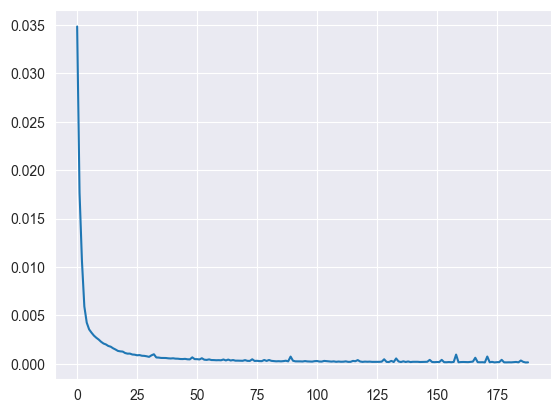

755/755 [==============================] - 1s 1ms/step
0.0001446153079830451
0.00014295610340275285
0.007149570083594528
  Hidden_Layer Neurons      Layout Params      MAE       MSE
0            3      32  [8, 16, 8]    362  0.00715  0.000143
Das kleinste Model ist:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 64        
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 2)                 18        
                                                                 
Total params: 362 (1.41 KB)
Trainable params: 362 (1.

C:\Users\teema\AppData\Local\Temp\ipykernel_10576\2128506288.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ergebnis_df = pd.concat([ergebnis_df, row], ignore_index=True)


In [12]:
#Select trained NN layouts:
layer_layout = [[8,16,8],[16,8,4]]

#Process Grid Search
s_mse_y = 1000
for layout in layer_layout:
    num_layer = len(layout)
    num_neurons = sum(layout)
    print("Number of Hidden Layers: ",num_layer," Number of Neurons: ", num_neurons)
    temp_model,history = train_model_test(layout)

    y_pred_scaled = temp_model.predict(X_test_scaled)

    num_params = temp_model.count_params()
    mse_y = mean_squared_error(y_test_scaled, y_pred_scaled)
    y_pred_val_scaled = temp_model.predict(X_val_scaled)
    mse_val = mean_squared_error(y_val_scaled, y_pred_val_scaled)
    print(mse_val)
    if (mse_y < s_mse_y):
          s_mse_y = mse_y
          s_model = temp_model
          s_pred = y_pred_scaled
    print(mse_y)
    mae_y = mean_absolute_error(y_test_scaled, y_pred_scaled)
    print(mae_y)

    row = pd.DataFrame([[num_layer, num_neurons,layout, num_params, mae_y, mse_y]], columns=ergebnis_columns)
    ergebnis_df = pd.concat([ergebnis_df, row], ignore_index=True)
print(ergebnis_df)
print("Das kleinste Model ist:")
s_model.summary()
y_pred_scaled = s_pred #Override results with the results of the best mse

In [ ]:
#Search for Pareto optimal solutions:
ergebnis_df['Neurons_Total'] = ergebnis_df['Neurons']
edf = ergebnis_df.sort_values(by='Neurons_Total')
min_rmse = edf.loc[edf.groupby('Neurons_Total')['MSE'].idxmin()]
pareto_front_temp = min_rmse.reset_index(drop=True)
pareto_front = pd.DataFrame(columns=edf.columns)

mse_temp = 1000
for index, row in pareto_front_temp.iterrows():
    if (row['MSE'] < mse_temp):
      pareto_front = pareto_front.append(row, ignore_index=True)
      mse_temp = row['MSE']
print(ergebnis_df)

print(pareto_front)

  Hidden_Layer Neurons      Layout Params       MAE      MSE Neurons_Total
0            3      32  [8, 16, 8]    362  0.007096  0.00014            32
  Hidden_Layer Neurons      Layout Params       MAE      MSE Neurons_Total
0            3      32  [8, 16, 8]    362  0.007096  0.00014            32


<ipython-input-18-5752792905c8>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pareto_front = pareto_front.append(row, ignore_index=True)


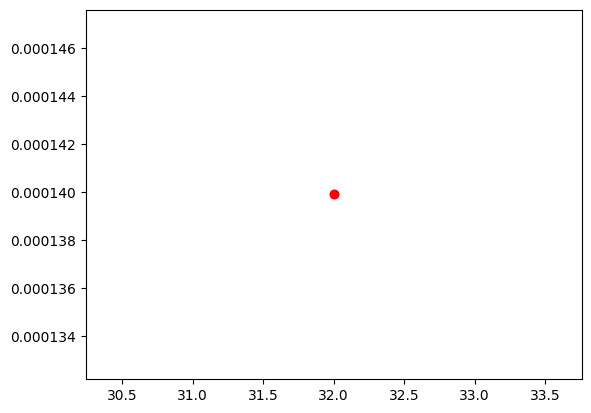

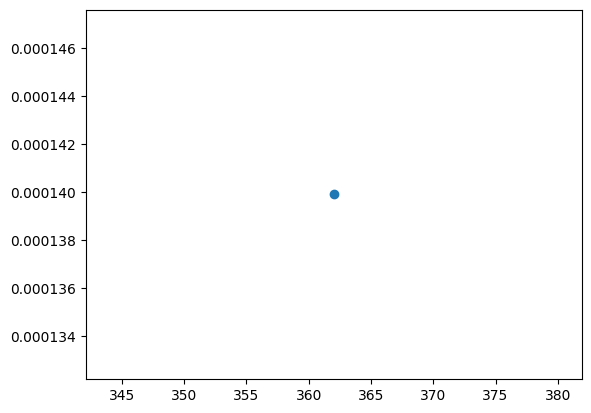

In [ ]:
#Plot Pareto Front
#plt.ylim(0,0.25)
plt.scatter(ergebnis_df['Neurons_Total'],ergebnis_df['MSE'])
plt.scatter(pareto_front['Neurons_Total'],pareto_front['MSE'], color='red')
plt.plot(pareto_front['Neurons_Total'],pareto_front['MSE'], color='red')
plt.show()
#plt.ylim(0,0.25)
plt.scatter(ergebnis_df['Params'],ergebnis_df['MSE'])
plt.show()

In [13]:
#Inverse scaling of Predictions
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test.info()
y_pred_df = pd.DataFrame(y_pred, columns=y_columns)
y_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 24152 entries, 866015 to 767462
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Value_SoH    24152 non-null  float64
 1   Value_NcT80  24152 non-null  float64
dtypes: float64(2)
memory usage: 566.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24152 entries, 0 to 24151
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Value_SoH    24152 non-null  float32
 1   Value_NcT80  24152 non-null  float32
dtypes: float32(2)
memory usage: 188.8 KB


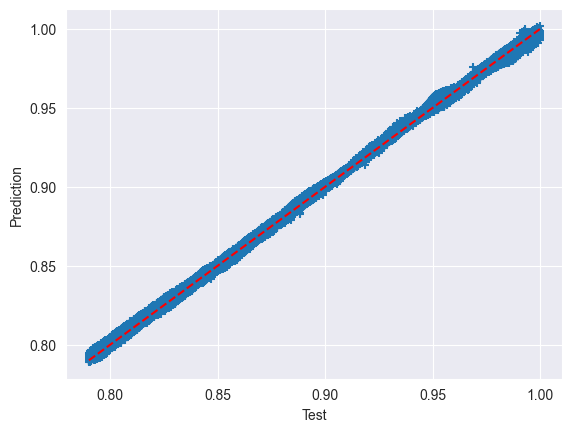

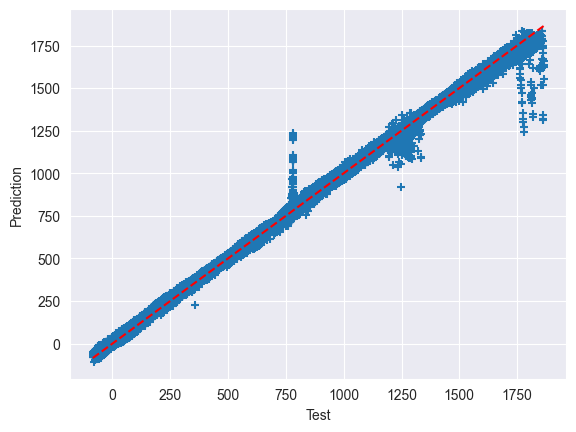

In [14]:
#Plot Predictions over Testvalues:
for pred_col in y_columns:
  plt.scatter(y_test[pred_col], y_pred_df[pred_col], marker='+')
  plt.plot([y_test[pred_col].min(), y_test[pred_col].max()], [y_test[pred_col].min(), y_test[pred_col].max()], color='red', linestyle='--')
  plt.xlabel('Test')
  plt.ylabel('Prediction')
  plt.show()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2024 entries, 0 to 2023
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             2024 non-null   int64  
 1   Value_U          2024 non-null   float64
 2   Value_I          2024 non-null   float64
 3   Value_SoC        2024 non-null   float64
 4   Cumulative_Ah    2024 non-null   float64
 5   Value_Age        2024 non-null   int64  
 6   Value_NumCharge  2024 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 110.8 KB
None
64/64 [==============================] - 0s 1ms/step
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2024 entries, 0 to 2023
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Value_SoH    2024 non-null   float32
 1   Value_NcT80  2024 non-null   float32
dtypes: float32(2)
memory usage: 15.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 

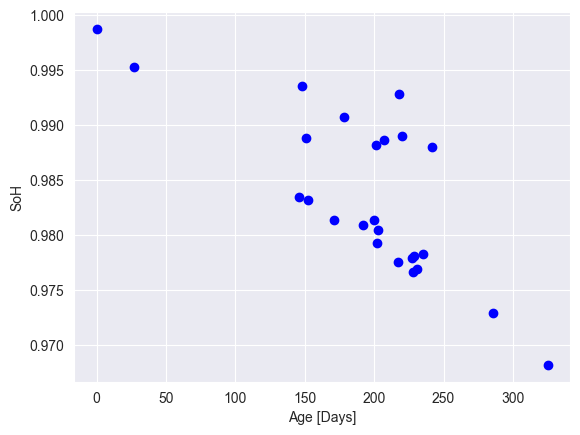

In [15]:
#Use best model with BPW data:
folder_bpw = 'data/BPW_CSV/'
contents_bpw = os.listdir(folder_bpw)
for content in contents_bpw:
  csv_bpw = os.path.join(folder_bpw, content)
  df_bpw = pd.read_csv(csv_bpw)
  bpw_columns = ['Time','Value_U','Value_I','Value_SoC','Cumulative_Ah','Value_Age','Value_NumCharge']
  #bpw_columns = ['Cumulative_Ah','Value_Age','Value_NumCharge']
  df_bpw = df_bpw[bpw_columns]

  print(df_bpw.info())
  bpw_scaled = scaler.transform(df_bpw)
  bpw_pred_scaled = temp_model.predict(bpw_scaled)
  bpw_pred = scaler_y.inverse_transform(bpw_pred_scaled)
  bpw_pred_df = pd.DataFrame(bpw_pred, columns=y_columns)
  bpw_pred_df.info()
  plt.scatter(df_bpw['Value_Age'].mean(),bpw_pred_df['Value_SoH'].mean(), color='blue')
plt.xlabel('Age [Days]')
plt.ylabel('SoH')
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2024 entries, 0 to 2023
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             2024 non-null   int64  
 1   Value_U          2024 non-null   float64
 2   Value_I          2024 non-null   float64
 3   Value_SoC        2024 non-null   float64
 4   Cumulative_Ah    2024 non-null   float64
 5   Value_Age        2024 non-null   int64  
 6   Value_NumCharge  2024 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 110.8 KB
None
64/64 [==============================] - 0s 909us/step
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2024 entries, 0 to 2023
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Value_SoH    2024 non-null   float32
 1   Value_NcT80  2024 non-null   float32
dtypes: float32(2)
memory usage: 15.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156

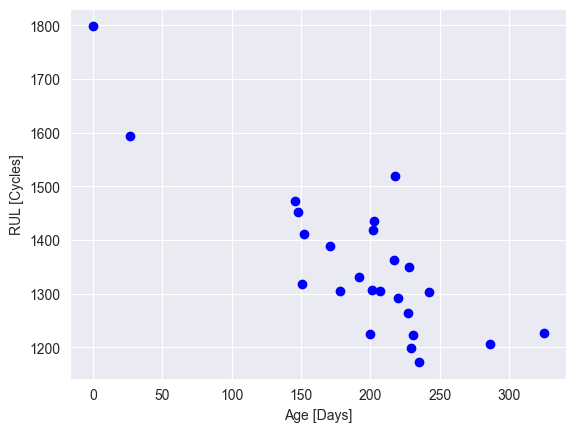

In [17]:
folder_bpw = 'data/BPW_CSV/'
contents_bpw = os.listdir(folder_bpw)
for content in contents_bpw:
  csv_bpw = os.path.join(folder_bpw, content)
  df_bpw = pd.read_csv(csv_bpw)
  #bpw_columns = ['Time','Value_U','Value_I','Value_SoC','Cumulative_Ah','Value_Age','Value_NumCharge']

  df_bpw = df_bpw[bpw_columns]
  print(df_bpw.info())
  bpw_scaled = scaler.transform(df_bpw)
  bpw_pred_scaled = temp_model.predict(bpw_scaled)
  bpw_pred = scaler_y.inverse_transform(bpw_pred_scaled)
  bpw_pred_df = pd.DataFrame(bpw_pred, columns=y_columns)
  bpw_pred_df.info()
  plt.scatter(df_bpw['Value_Age'].mean(),bpw_pred_df['Value_NcT80'].mean(), color='blue')
plt.ylabel('RUL [Cycles]')
plt.xlabel('Age [Days]')
plt.show()